In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc

import netCDF4
import numpy as np
import xarray as xr
from cftime import num2pydate
from metpy.units import units
from siphon.catalog import TDSCatalog
from xarray.backends import NetCDF4DataStore

from data import GetGFSData
from indices import CalculateIndices

from charts import CalculateCharts
from variables import ExtractVariables

In [2]:
data = xr.open_dataset('data.nc')

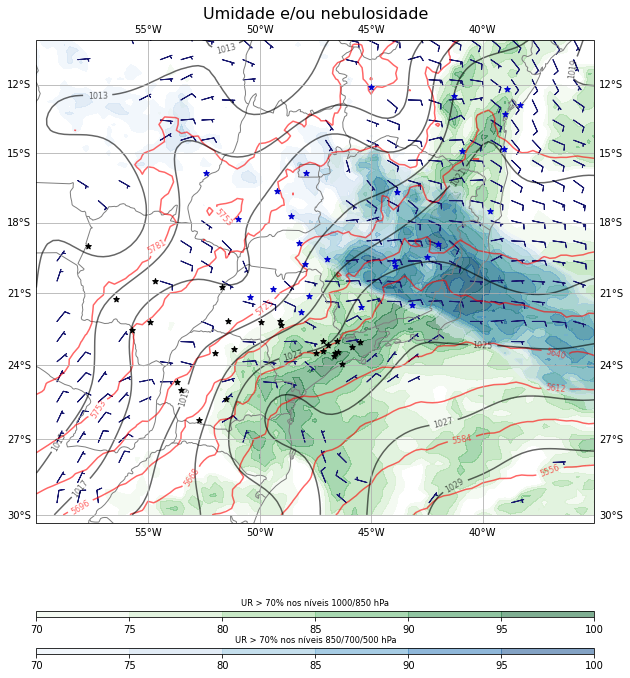

In [3]:
charts = CalculateCharts(data)
clouds = charts.clouds_humidity()
plt.savefig('test.jpg')

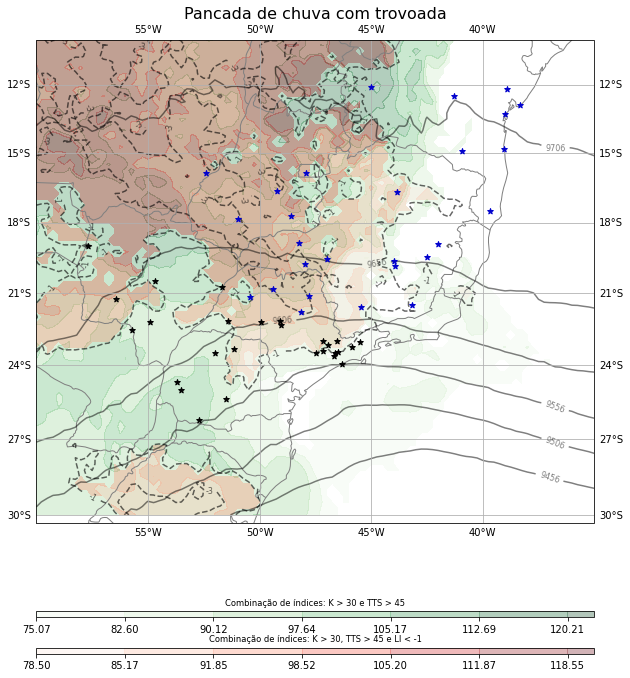

In [4]:
charts = CalculateCharts(data)
showers = charts.showers_heat_humidity()
plt.savefig('test2.jpg')

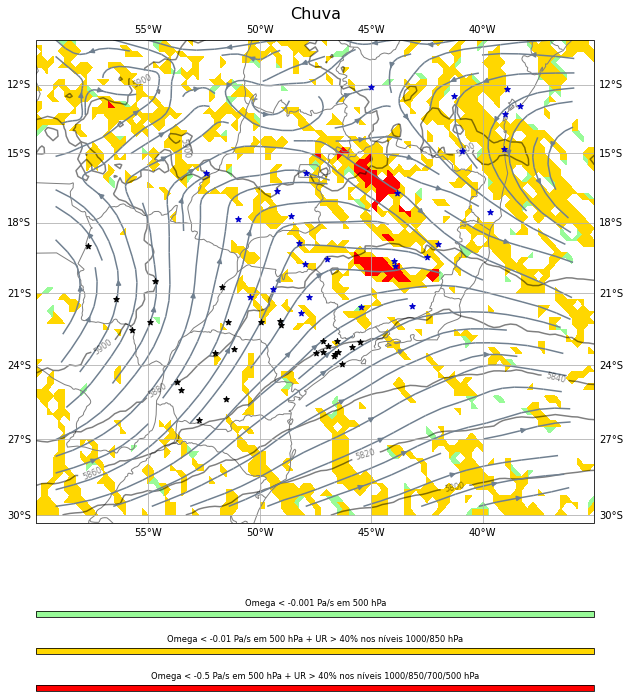

In [5]:
charts = CalculateCharts(data)
rain = charts.rain()
plt.savefig('test3.jpg')

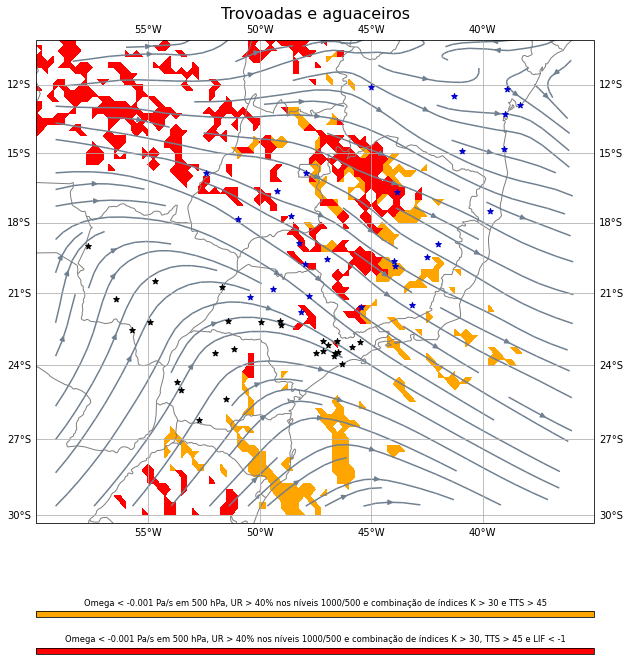

In [6]:
charts = CalculateCharts(data)
rain = charts.thunderstorm_showers()
plt.savefig('test4.jpg')

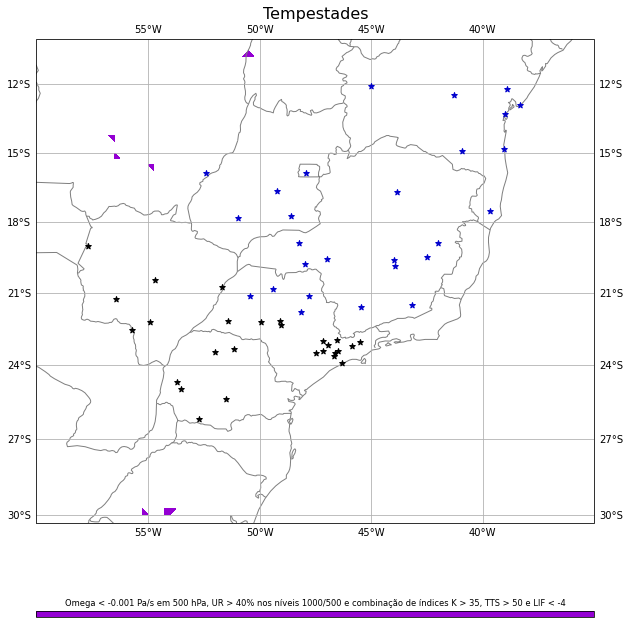

In [3]:
charts = CalculateCharts(data)
rain = charts.storms()
plt.savefig('test5.jpg')

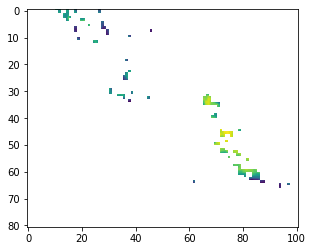

In [10]:
import matplotlib.pyplot as plt
variables = ExtractVariables(data)

omega_500 = variables.omega(500)
rhum_1000 = variables.relative_humidity(1000)
rhum_850 = variables.relative_humidity(850)
rhum_700 = variables.relative_humidity(700)
rhum_500 = variables.relative_humidity(500)
hgpt_500 = variables.geopotential_height(500)

# This will help with the calculations later on
omega_500 = omega_500.values

# OMEGA < -0.001 (green contourf)
# Define conditions
condition = omega_500 < -0.001
omega_500_m001 = (omega_500 * condition)
omega_500_m001[omega_500_m001 == 0] = np.nan

# OMEGA < -0.01 and UR > 40% average(1000/850) (orange contourf)
# Define conditions
rhum_1000_850 = (rhum_1000.values + rhum_850.values) / 2
condition = (omega_500 < -0.01) & (rhum_1000_850 > 40)
omega_500_m01 = (omega_500 * condition) + (rhum_1000_850 * condition)
omega_500_m01[omega_500_m01 == 0] = np.nan

# OMEGA < -0.5 and UR > 70% average(1000/850/700/500) (red contourf)
# Define conditions
rhum_1000_850_700_500 = (
    rhum_1000.values + rhum_850.values + rhum_700.values + rhum_500.values) / 4
condition = (omega_500 < -0.5) & (rhum_1000_850_700_500 > 70)
omega_500_m5 = (omega_500 * condition) + (rhum_1000_850_700_500 * condition)
omega_500_m5[omega_500_m5 == 0] = np.nan

plt.imshow(omega_500_m5)

In [6]:
indices = CalculateIndices(data)
k_index = indices.k()
tt_index = indices.tt()
li_index = indices.li()

condition = (k_index > 30) & (tt_index > 45) & (li_index < -1)
k_30_tt_45_li_m1 = (k_index * condition) + (tt_index * condition) + (li_index * condition)
k_30_tt_45_li_m1[k_30_tt_45_li_m1 == 0] = np.nan
# levels = np.arange(k_30_tt_45_li_m1.min(), k_30_tt_45_li_m1.max(), (k_30_tt_45_li_m1.max() - k_30_tt_45_li_m1.min()) / 3)

In [22]:
np.nanmax(k_30_tt_45_li_m1)

120.909935

In [4]:
URL = 'http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml'
dataset = 'Latest Collection for GFS Quarter Degree Forecast'

variables = ['Relative_humidity_isobaric',
             'Temperature_isobaric',
             'u-component_of_wind_isobaric',
             'v-component_of_wind_isobaric',
             'Best_4_layer_Lifted_Index_surface',
             'Geopotential_height_isobaric',
             'Precipitable_water_entire_atmosphere_single_layer',
             'Pressure_reduced_to_MSL_msl',
             'Vertical_velocity_pressure_isobaric']

gfs = GetGFSData(variables)
data = gfs.get()
data.to_netcdf('data.nc')

Process done in 26.84421181678772 seconds
